<a href="https://colab.research.google.com/github/matteolimoncini/COVID-19-search-engine/blob/main/COVID_19_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install split-folders
!pip install clustimage

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import os
import urllib.request
import IPython.display as display
import shutil
import pickle
import time

from PIL import Image 
from random import randint
from scipy.spatial import distance

from clustimage import Clustimage

from keras.models import Model
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
kaggle_path = '.kaggle'
if not (os.path.exists(kaggle_path)):
  !mkdir ~/.kaggle
  !echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json

#sarscov2 ctscan dataset

In [14]:
%%capture
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip sarscov2-ctscan-dataset.zip -d sarscov2-ctscan-dataset
!rm sarscov2-ctscan-dataset.zip

## Classification


check images size

In [15]:
folder_images = "./sarscov2-ctscan-dataset"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

sizes = []
for keys,values in size_images.items():
  sizes.append((values.get('width'),values.get('heigth')))


max_width = max(sizes,key=lambda item:item[0])[0]
min_width = min(sizes,key=lambda item:item[0])[0]
max_heigth = (max(sizes,key=lambda item:item[1])[1])
min_heigth = (min(sizes,key=lambda item:item[1])[1])
print ('max width images: '+str(max_width)+'\n'+'min width images: '+str(min_width))
print ('max heigth images: '+str(max_heigth)+'\n'+'min heigth images: '+str(min_heigth))

max width images: 534
min width images: 182
max heigth images: 416
min heigth images: 119


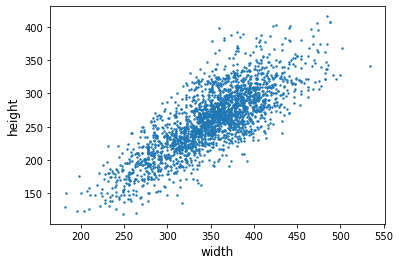

In [16]:
x = [i[0] for i in sizes]
y = [i[1] for i in sizes]
plt.scatter(x, y, s=2)
plt.xlabel('width', fontsize='large')
plt.ylabel('height', fontsize = 'large')
plt.show()

Is the dataset balanced?

In [17]:
covid = len(os.listdir('./sarscov2-ctscan-dataset/COVID'))
no_covid = len(os.listdir('./sarscov2-ctscan-dataset/non-COVID'))

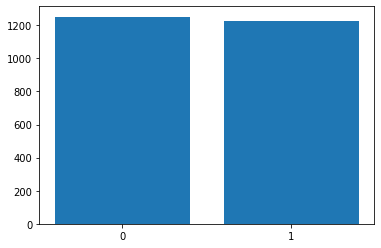

In [18]:
plt.bar([0,1], [covid, no_covid])
plt.xticks(np.arange(0, 2, 1))
plt.show()

In [19]:
TRAINING_DIR = '/content/splitted_img/train'
VALIDATION_DIR = '/content/splitted_img/val'
TEST_DIR = '/content/splitted_img/test'
IMG_SIZE = 256
BATCH_SIZE = 64
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 10

split dataset in a random way. 80% training, 10% test, 10% validation

In [20]:
splitfolders.ratio("./sarscov2-ctscan-dataset", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2481 files [00:01, 1800.50 files/s]


In [21]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale', 
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALIDATION_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

Found 1984 files belonging to 2 classes.
Found 247 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


normalize pixel values from 0 to 1 instead of 0-255

In [ ]:
def normalize_data(ds, shuffle = False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_ds = normalized_ds.cache()

    if shuffle:
      normalized_ds = normalized_ds.shuffle(2000, seed=RANDOM_SEED)
    
    normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)
    return normalized_ds
  
train_ds = normalize_data(train_dataset, True)
val_ds = normalize_data(val_dataset, False)
test_ds = normalize_data(test_dataset)

## Classification using a convolutional neural network

In [ ]:
def first_cnn():
  model_cnn = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same'),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128, activation='relu'),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_cnn

In [ ]:
first_try_cnn = first_cnn()

In [ ]:
first_try_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
EPOCHS=8

In [ ]:
#@markdown Code to display dynamically loss and accuracy curve

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(14,9))

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = len(train_dataset)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend(prop={'size':14})
    self.axes[1].legend(prop={'size':14})
    self.axes[0].set_xlabel('epochs',fontsize=14)
    self.axes[1].set_xlabel('epochs',fontsize=14)
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [ ]:
plot_training = PlotTraining(sample_rate=10, zoom=1)

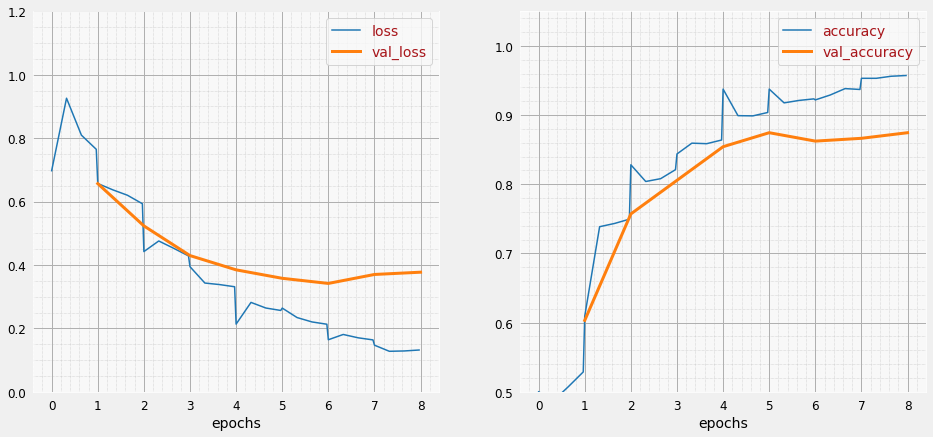

31/31 [==============================] - 35s 1s/step - loss: 0.1318 - accuracy: 0.9572 - val_loss: 0.3772 - val_accuracy: 0.8745


In [ ]:
history = first_try_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, verbose = 1,
  callbacks=[plot_training]
)
!mkdir -p saved_model
first_try_cnn.save('saved_model/my_model_firstry')

## Clustering

The idea is to use a cluster algorithm to divide in two clusters: images with covid sympthoms and images without covid sympthoms.
In this case we use only images without label, unsupervised learning.


In [ ]:
path_images = r'/content/sarscov2-ctscan-dataset'

In [ ]:
def check_results(clusters):
  if(len(clusters)!=2):
    print("num clusters detected not correct.")
    print("num clusters detected: "+str(len(clusters)))

  else:
    for i,cluster in enumerate(clusters.values()):
      count_non=0
      count = 0
      for elem in cluster: 
        if 'Non' in elem: 
          count_non += 1
        else:
          count +=1

      print("\n% img without covid in cluster " + str(i) + " : " + str(round(count_non/len(cluster)*100,2)))
      print("% img with covid in cluster " + str(i) + " : " + str(round(count/len(cluster)*100,2)))


  return 

### Clustering with hog method

In [ ]:
# Initialize
cl = Clustimage(method = 'hog', params_hog={'orientations':8, 'pixels_per_cell':(4,4), 'cells_per_block':(1,1)})

# Load dataset
pathnames = cl.import_data(path_images)

[clustimage] >WARNING> Parameter grayscale is set to True coz you are using method="hog"
[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:08<00:00, 295.21it/s]


In [ ]:
# Preprocessing of the first image
# color scale 0:cv2.IMREAD_GRAYSCALE 1:cv2.IMREAD_COLOR 
img = cl.imread(pathnames['pathnames'][0], dim=(128,128), colorscale=1, flatten=True)
# Extract HOG features
img_hog = cl.extract_hog(img, pixels_per_cell=(4,4), orientations=8, flatten=False)

100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


In [ ]:
%%capture

list_hog =[]
for image in pathnames['pathnames']:
  img = cl.imread(image, dim=(128,128), colorscale=1, flatten=True)
  img_hog = cl.extract_hog(img, pixels_per_cell=(4,4), orientations=8, flatten=False)
  list_hog.append(img_hog)

Text(0.5, 1.0, 'HOG')

<Figure size 1008x648 with 0 Axes>

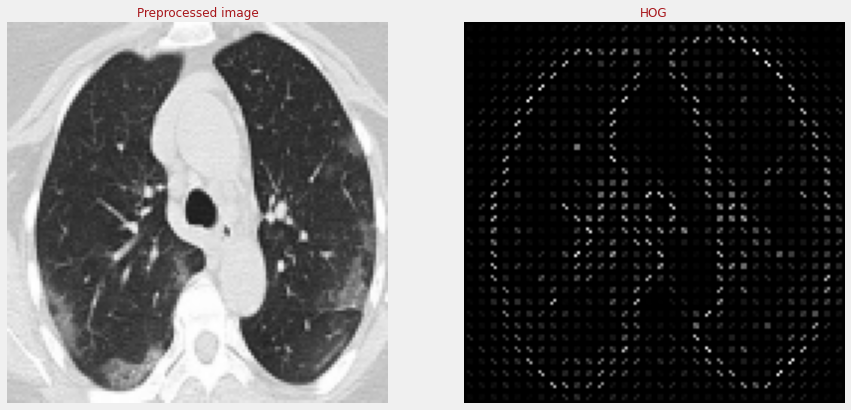

In [ ]:
plt.figure();
fig,axs=plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(img.reshape(128,128,3))
axs[0].axis('off')
axs[0].set_title('Preprocessed image', fontsize=12)
axs[1].imshow(img_hog, cmap='gray')
axs[1].axis('off')
axs[1].set_title('HOG', fontsize=12)

In [ ]:
len(list_hog)

2481

In [ ]:
results = cl.fit_transform(pathnames['pathnames'],
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=4,
                           cluster_space='high')

[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:08<00:00, 277.95it/s]
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 2481/2481 [04:36<00:00,  8.97it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=2481, features=16384
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 16384) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


check results

In [ ]:
groups = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
check_results(groups)


% img without covid in cluster 0 : 50.43
% img with covid in cluster 0 : 49.57

% img without covid in cluster 1 : 48.58
% img with covid in cluster 1 : 51.42


### clustering with pca without fixing a number of clusters


In [ ]:
# init with PCA method
# cl = Clustimage(method='pca')
cl = Clustimage(method='pca',
                embedding='tsne',
                grayscale=False,
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation
results = cl.fit_transform(X,
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=5,
                          cluster_space='high')
results.keys()

[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:11<00:00, 219.72it/s]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.


['/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (51).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (572).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (345).png' ...
 '/content/sarscov2-ctscan-dataset/COVID/Covid (285).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (702).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (730).png']


100%|██████████| 2481/2481 [00:10<00:00, 226.14it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [578] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=2481, features=578
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 3/3 [00:00<00:00,  5.82it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 578) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'url', 'filenames'])

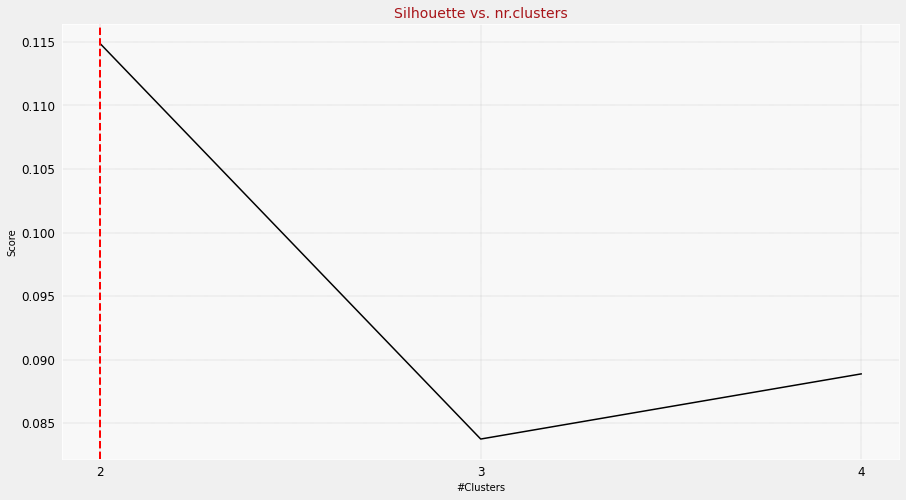

[clusteval] >Estimated number of n_clusters: 2, average silhouette_score=0.271


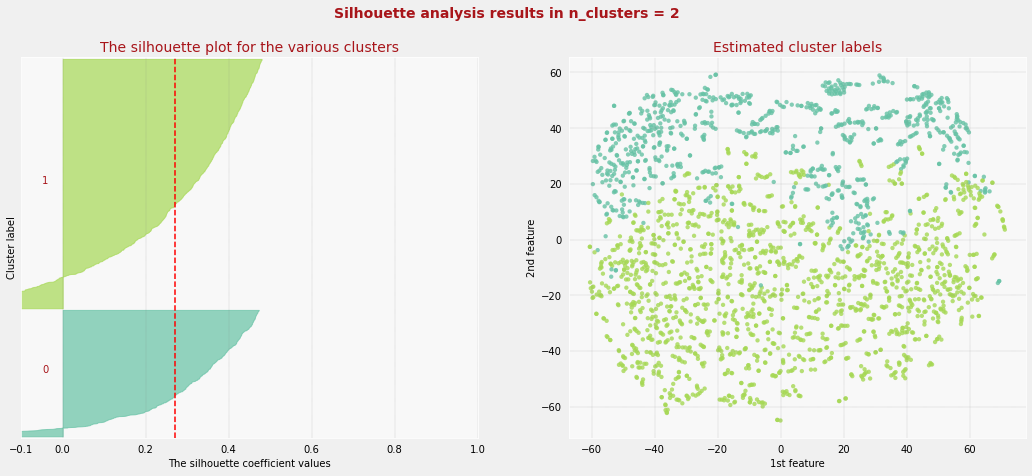

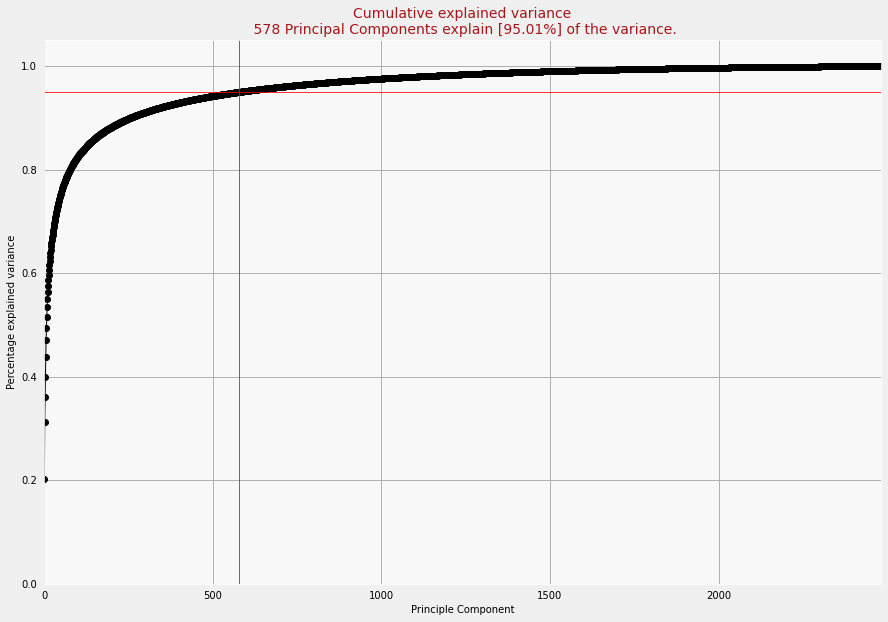

[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=286628.877. Be patient now..
[clusteval] >Compute cluster labels.


<Figure size 1008x648 with 0 Axes>

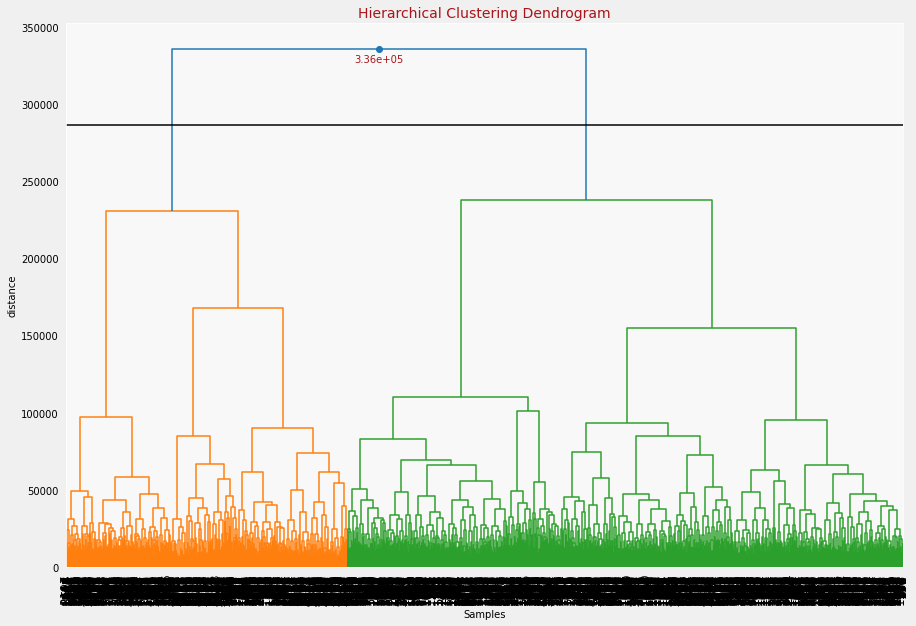

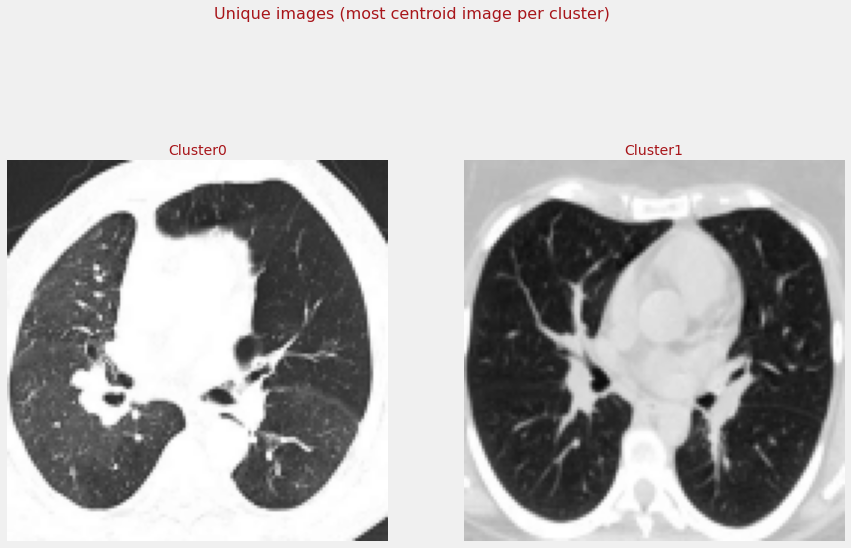

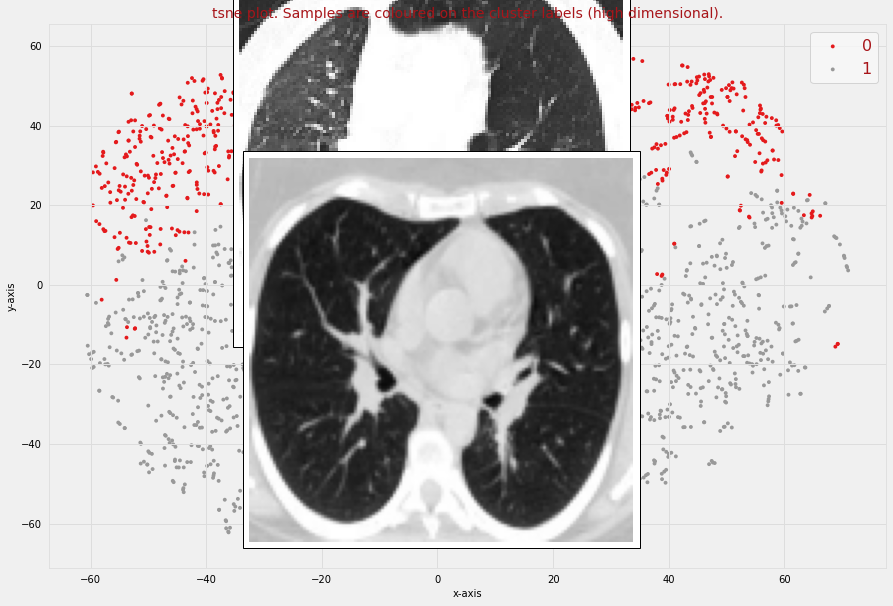

<Figure size 1008x648 with 0 Axes>

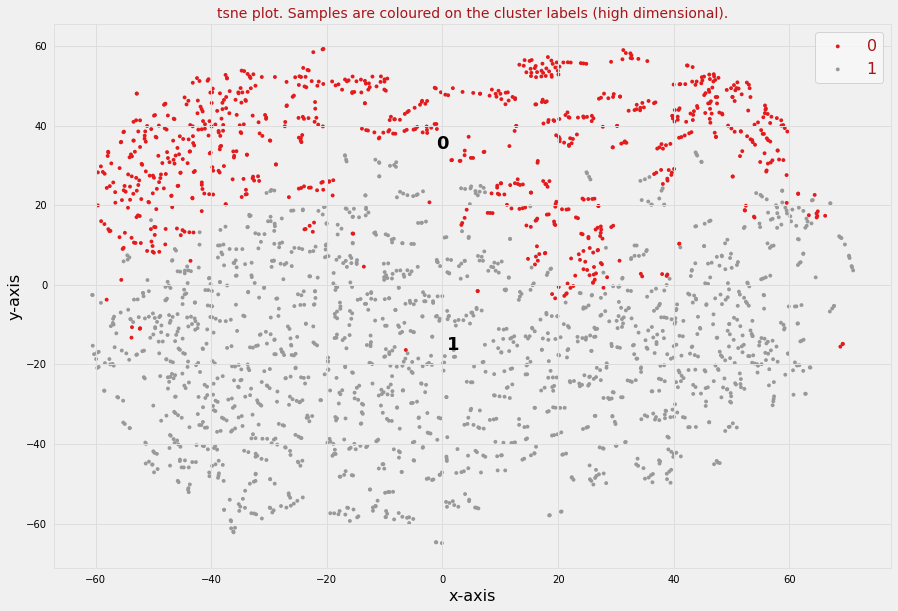

<Figure size 1008x648 with 0 Axes>

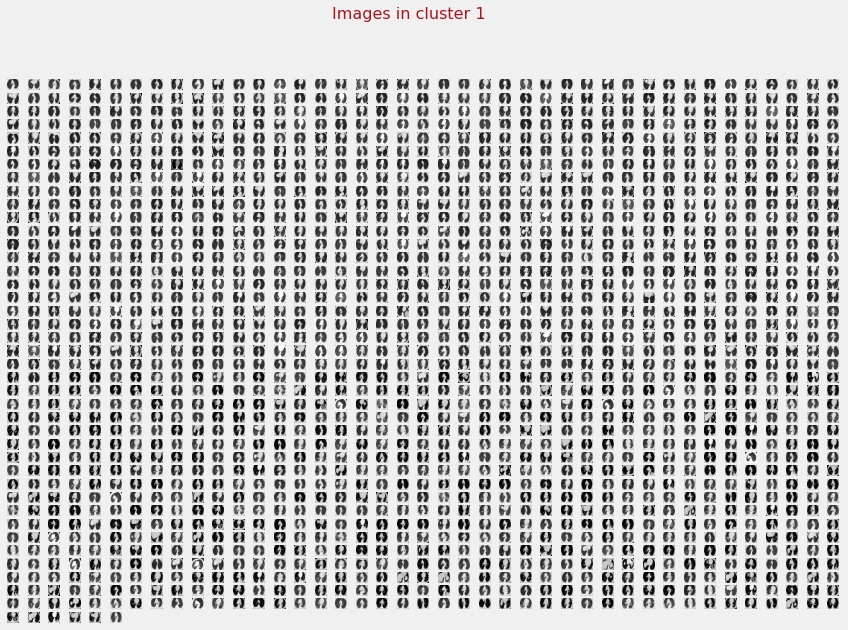

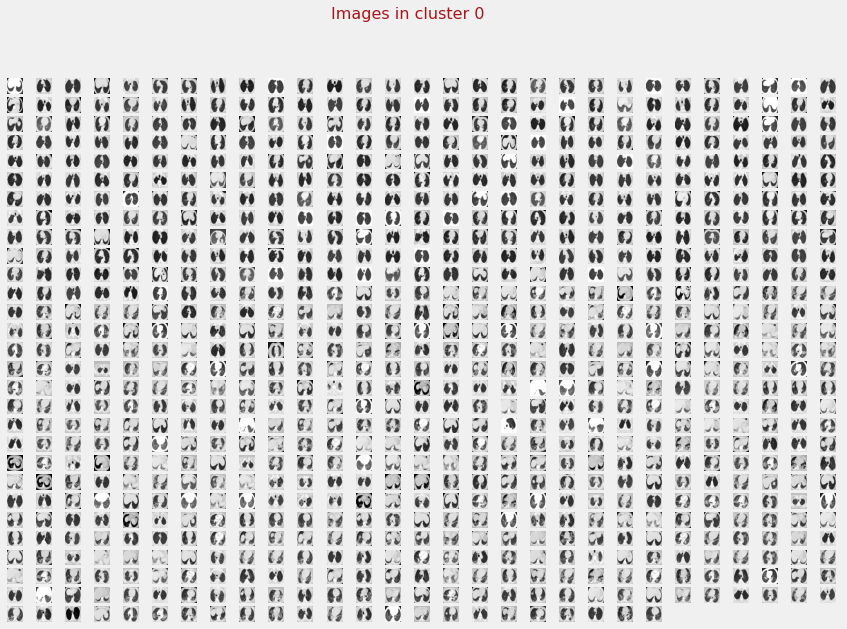

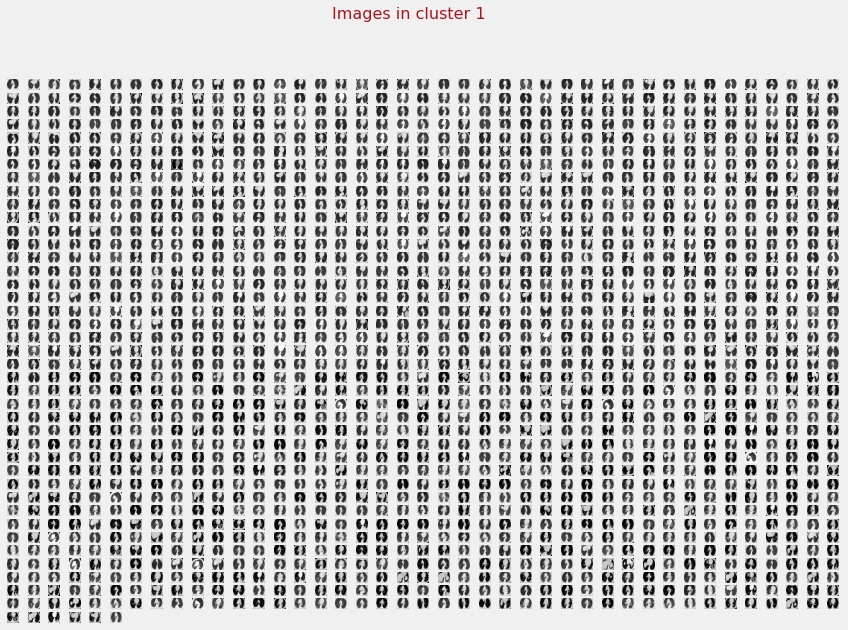

In [ ]:
# Silhouette plots
cl.clusteval.plot()
cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
cl.pca.plot()

# Dendrogram
cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
cl.scatter(zoom=3, img_mean=False)
cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')

Check results

In [ ]:
groups = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
check_results(groups)


% img without covid in cluster 0 : 54.8
% img with covid in cluster 0 : 45.2

% img without covid in cluster 1 : 39.16
% img with covid in cluster 1 : 60.84


### clustering with pca method fixing 2 clusters

In [ ]:
# init with PCA method
# cl = Clustimage(method='pca')
cl = Clustimage(method='pca',
                embedding='tsne',
                grayscale=False,  
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation
results = cl.fit_transform(X,
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=2,
                           cluster_space='high')
results.keys()

[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:11<00:00, 220.55it/s]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.


['/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (51).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (572).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (345).png' ...
 '/content/sarscov2-ctscan-dataset/COVID/Covid (285).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (702).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (730).png']


100%|██████████| 2481/2481 [00:11<00:00, 217.76it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [578] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=2481, features=578
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


0it [00:00, ?it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 578) feature-space.


[clusteval] >No clusters detected.
[clusteval] >Optimal number clusters detected: [1].
[clusteval] >Fin.


dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'url', 'filenames'])

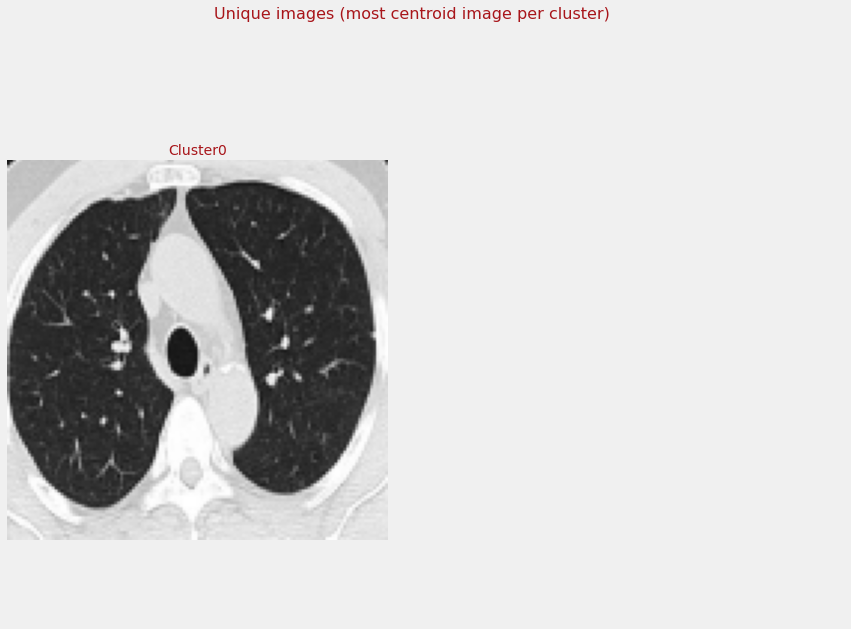

In [ ]:
# Silhouette plots
#cl.clusteval.plot()
#cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
#cl.pca.plot()

# Dendrogram
#cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
#cl.scatter(zoom=3, img_mean=False)
#cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')

Check results

In [ ]:
groups = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
check_results(groups)

num clusters detected not correct.
num clusters detected: 1


### clustering with hog method fixing 2 cluster

In [ ]:
# init with hog method
cl = Clustimage(method='hog',
                embedding='tsne',
                grayscale=False,
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation

results = cl.fit_transform(X,
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=2,
                          cluster_space='high')
results.keys()

[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:08<00:00, 291.89it/s]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.


['/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (51).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (572).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (345).png' ...
 '/content/sarscov2-ctscan-dataset/COVID/Covid (285).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (702).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (730).png']


100%|██████████| 2481/2481 [00:08<00:00, 295.55it/s]
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 2481/2481 [01:10<00:00, 35.33it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=2481, features=16384
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


0it [00:00, ?it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 16384) feature-space.


[clusteval] >No clusters detected.
[clusteval] >Optimal number clusters detected: [1].
[clusteval] >Fin.


dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'url', 'filenames'])

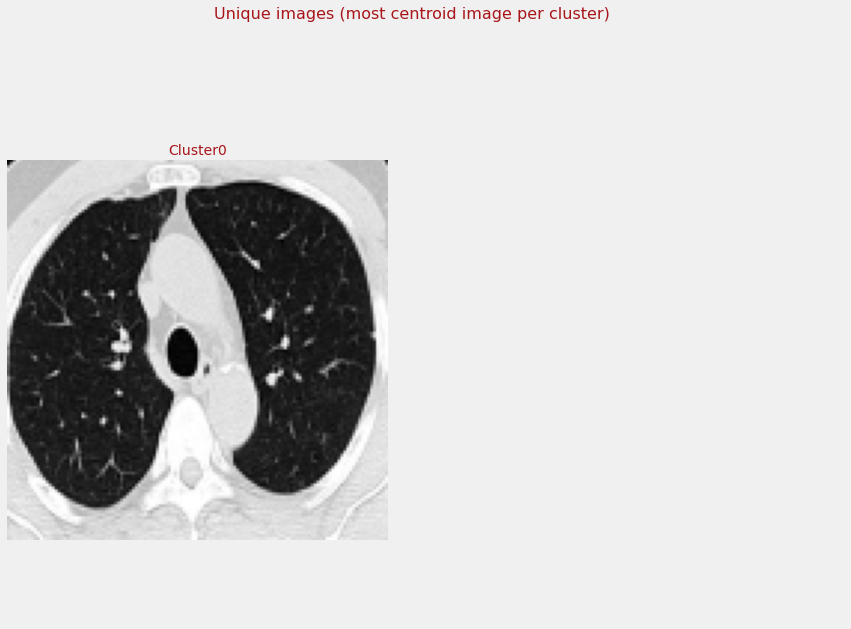

In [ ]:
# Silhouette plots
#cl.clusteval.plot()
#cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
#cl.pca.plot()

# Dendrogram
#cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
#cl.scatter(zoom=3, img_mean=False)
#cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')

Check results

In [ ]:
groups = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
check_results(groups)

num clusters detected not correct.
num clusters detected: 1


### clustering using VGG + TSNE + KMeans

In [ ]:
# import dati
path_images = '/content/sarscov2-ctscan-dataset'

In [ ]:
source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [ ]:
# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
img_filenames = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the img_filenames list
            img_filenames.append(file.name)

In [ ]:
# preprocessing and loading images

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# model
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

553476096/553467096 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
data = {}
p = r"/content"

# lop through each image in the dataset
for img_fn in img_filenames:
    # try to extract the features and update the dictionary
    try:
          feat = extract_features(img_fn,model)
        data[img_fn] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

In [ ]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [ ]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(2481, 1, 4096)

In [ ]:
# reshape so that there are 2481 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(2481, 4096)

In [ ]:
x_tsne = TSNE().fit_transform(feat)

In [ ]:
#print(f"Components before PCA: {feat.shape[1]}")
#print(f"Components after PCA: {pca.n_components}")

In [ ]:
# KMeans
kmeans = KMeans(n_clusters=2, random_state=22)
kmeans.fit(x_tsne)

KMeans(n_clusters=2, random_state=22)

In [ ]:
kmeans.labels_

array([0, 1, 1, ..., 0, 1, 1], dtype=int32)

Check results

In [ ]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
check_results(groups)


% img without covid in cluster 0 : 52.49
% img with covid in cluster 0 : 47.51

% img without covid in cluster 1 : 46.56
% img with covid in cluster 1 : 53.44


### Using a convolutional neural network to do feature extraction, then using kmeans algorithm

In [ ]:
second_model = tf.keras.models.load_model('/content/saved_model/my_model_firstry')
second_model = Model(inputs = second_model.inputs, outputs = second_model.layers[-2].output)
second_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0   

In [ ]:
# create images


source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [ ]:
path_images = '/content/sarscov2-ctscan-dataset'

In [ ]:
# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
immagini = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the immagini list
            immagini.append(file.name)

In [ ]:
img = load_img(immagini[0], target_size=(256, 256))
img = np.array(img)
img.shape

(256, 256, 3)

In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(256,256))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(256,256,1) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
data = {}
p = r"/content/tmp"

# loop through each image in the dataset
for img_fn in immagini:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(img_fn,second_model)
        data[img_fn] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

Check results

In [ ]:
groups = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
check_results(groups)

num clusters detected not correct.
num clusters detected: 1


first example of a query

extract all images that have covid-19 symptoms

## Image similarity

#### Test flattened image similarity with VGG 16 lookalike

In [9]:
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url)
model = tf.keras.Sequential([layer])

In [10]:
def extract(file):
  file = Image.open(file).convert('L').resize(IMAGE_SHAPE)
  #display(file)

  file = np.stack((file,)*3, axis=-1)

  file = np.array(file)/255.0

  embedding = model.predict(file[np.newaxis, ...])
  #print(embedding)
  vgg16_feature_np = np.array(embedding)
  flattended_feature = vgg16_feature_np.flatten()

  #print(len(flattended_feature))
  #print(flattended_feature)
  #print('-----------')
  return flattended_feature

In [22]:
path = '/content/sarscov2-ctscan-dataset/COVID/Covid (1).png'

In [23]:
cov_test = extract(path)

In [24]:
cov_test

array([0.        , 0.        , 0.22939235, ..., 0.06076321, 0.01597164,
       0.        ], dtype=float32)

In [25]:
source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

path_images = '/content/sarscov2-ctscan-dataset'

# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
immagini = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the immagini list
            immagini.append(file.name)

In [26]:
len(immagini)

2481

In [27]:
start_time = time.time()
data = {}
for img in immagini:
  immagine = extract(img)
  data[img] = immagine
print("--- %s seconds ---" % (time.time() - start_time))

--- 250.48363327980042 seconds ---


In [28]:
keys, values = list(data.keys()), list(data.values())
print(len(keys), len(values))

2481 2481


In [29]:
df_images = pd.DataFrame(values, index=keys)

In [30]:
df_images.head(5)

0     1         2     3     4         5     6     \
Non-Covid (367).png  0.027199   0.0  0.435171   0.0   0.0  0.277628   0.0   
Covid (339).png      0.000000   0.0  0.805860   0.0   0.0  1.809237   0.0   
Non-Covid (120).png  0.000000   0.0  0.848801   0.0   0.0  0.851514   0.0   
Non-Covid (876).png  0.020620   0.0  0.383188   0.0   0.0  1.187043   0.0   
Covid (505).png      0.066649   0.0  0.317088   0.0   0.0  1.530700   0.0   

                         7         8         9     ...      1270      1271  \
Non-Covid (367).png  0.000000  0.175796  0.109908  ...  0.000000  0.013386   
Covid (339).png      0.000000  0.019728  0.241926  ...  0.154375  0.168428   
Non-Covid (120).png  0.000000  0.405271  0.037785  ...  0.361444  0.165891   
Non-Covid (876).png  0.000000  0.008053  0.276565  ...  0.645043  0.598659   
Covid (505).png      0.007738  0.006122  0.091355  ...  0.229366  0.182787   

                         1272      1273      1274      1275      1276  \
Non-Covid (367).png  0.000000  0.089782  0.463036  0.023300  0.000000   
Covid (339).png      0.000000  0.000000  0.000000  0.207641  0.000000   
Non-Covid (120).png  0.000000  0.037590  0.495010  0.018328  0.014049   
Non-Covid (876).png  0.000000  0.055334  0.507593  0.102806  0.817921   
Covid (505).png      0.001204  0.369638  1.263471  0.000000  0.053811   

                         1277      1278  1279  
Non-Covid (367).png  0.117588  0.063652   0.0  
Covid (339).png      0.091209  0.069172   0.0  
Non-Covid (120).png  0.054163  0.013582   0.0  
Non-Covid (876).png  0.029317  0.158047   0.0  
Covid (505).png      0.182907  0.005493   0.0  

[5 rows x 1280 columns]

#### scipy distance test

In [31]:
# euclidean (default parameter distance_matrix p = 2)

from scipy.spatial import distance_matrix

euclidean = pd.DataFrame(distance_matrix(df_images.values, df_images.values), index=df_images.index, columns=df_images.index)

In [32]:
euclidean.head(5)

Non-Covid (367).png  Covid (339).png  \
Non-Covid (367).png             0.000000        13.741068   
Covid (339).png                13.741068         0.000000   
Non-Covid (120).png             8.190332        12.611982   
Non-Covid (876).png            14.020372        11.981366   
Covid (505).png                13.378852        12.846579   

                     Non-Covid (120).png  Non-Covid (876).png  \
Non-Covid (367).png             8.190332            14.020372   
Covid (339).png                12.611982            11.981366   
Non-Covid (120).png             0.000000            12.490716   
Non-Covid (876).png            12.490716             0.000000   
Covid (505).png                11.524950            12.336083   

                     Covid (505).png  Covid (1135).png  Non-Covid (605).png  \
Non-Covid (367).png        13.378852         13.200981            13.039137   
Covid (339).png            12.846579         12.607534            12.003204   
Non-Covid (120).png        11.524950         10.810856            11.221421   
Non-Covid (876).png        12.336083         11.080185            12.219017   
Covid (505).png             0.000000         10.674431             9.746710   

                     Non-Covid (1185).png  Non-Covid (1222).png  \
Non-Covid (367).png             11.963375             12.105336   
Covid (339).png                 14.540432             12.466550   
Non-Covid (120).png             11.859336             12.040411   
Non-Covid (876).png             14.086536             13.399436   
Covid (505).png                 14.103547             13.721614   

                     Covid (1052).png  ...  Non-Covid (172).png  \
Non-Covid (367).png         16.701952  ...            15.888005   
Covid (339).png             14.919084  ...            13.965780   
Non-Covid (120).png         15.941126  ...            15.702222   
Non-Covid (876).png         14.977882  ...            13.914378   
Covid (505).png             15.422140  ...            15.916830   

                     Covid (1252).png  Covid (1178).png  Non-Covid (220).png  \
Non-Covid (367).png         15.868858         11.907258            10.306046   
Covid (339).png             15.887003         12.916783            13.670362   
Non-Covid (120).png         15.643593          9.872314             9.103273   
Non-Covid (876).png         15.608553         11.918212            12.727032   
Covid (505).png             16.116771         11.317857            14.305549   

                     Covid (298).png  Covid (1004).png  Covid (1063).png  \
Non-Covid (367).png        14.474536         16.732037         13.407994   
Covid (339).png            13.950387         15.987570         15.137000   
Non-Covid (120).png        14.906484         16.486836         13.738638   
Non-Covid (876).png        15.948698         16.428507         14.794980   
Covid (505).png            15.499127         15.480207         14.885057   

                     Non-Covid (339).png  Covid (290).png  Non-Covid (308).png  
Non-Covid (367).png            17.281146        14.066286            13.104188  
Covid (339).png                16.470269        14.914398            13.126803  
Non-Covid (120).png            17.080813        14.607039            11.486891  
Non-Covid (876).png            15.997154        15.668709            12.345528  
Covid (505).png                18.463207        15.461429            12.947141  

[5 rows x 2481 columns]

In [33]:
euclidean['Covid (11).png'].nsmallest(10)

Covid (11).png          0.000000
Covid (9).png           9.339832
Covid (7).png          10.534321
Covid (10).png         10.587842
Covid (8).png          11.183355
Covid (5).png          11.869768
Covid (990).png        12.771029
Covid (991).png        12.992751
Covid (1023).png       13.103287
Non-Covid (273).png    13.309546
Name: Covid (11).png, dtype: float64

In [34]:
euclidean['Covid (11).png'].nlargest(10)

Covid (968).png         21.854252
Non-Covid (1194).png    20.915825
Non-Covid (1195).png    20.833295
Non-Covid (1192).png    20.795939
Non-Covid (1091).png    20.772245
Covid (246).png         20.710167
Non-Covid (1193).png    20.523328
Non-Covid (942).png     20.510189
Non-Covid (607).png     20.479815
Non-Covid (1191).png    20.441407
Name: Covid (11).png, dtype: float64

In [35]:
euclidean['Covid (118).png'].nsmallest(10)[1:]

Covid (117).png     6.963199
Covid (119).png     7.054840
Covid (115).png     8.459534
Covid (121).png     8.943242
Covid (116).png     9.874227
Covid (114).png    10.145262
Covid (120).png    10.330868
Covid (187).png    10.885776
Covid (113).png    10.928651
Name: Covid (118).png, dtype: float64

#### Cosine distance

In [36]:
len(values)

2481

In [37]:
result=np.zeros((len(values), len(values)))
for i in range(len(values)):
  for j in range(len(values)):
    result[i][j] = distance.cosine(values[i], values[j])

cosine_df = pd.DataFrame(result, columns = keys, index = keys)

In [39]:
#@title query { run: "auto" }
#inizialize 


#@markdown Estrai le 10 immagini più simili dell'immagine indicata e secondo la metrica { run: "auto" }
metrica = "euclidean" #@param ["euclidean", "cosine"]
file_name = "Covid (17).png" #@param {type:"string"}

if len(file_name.strip())!=0:
  if metrica == "euclidean":
    res = euclidean[file_name].nsmallest(11)[1:]
  else:
    res = cosine_df[file_name].nsmallest(11)[1:]

print("Le 10 immagini più simili sono\n", res)

Le 10 immagini più simili sono
 Covid (18).png          6.758857
Covid (16).png          7.285912
Covid (15).png          8.964248
Covid (19).png          9.993107
Covid (21).png         10.301604
Covid (22).png         10.749321
Covid (23).png         10.859654
Non-Covid (124).png    10.961504
Non-Covid (117).png    10.986357
Covid (24).png         11.072608
Name: Covid (17).png, dtype: float64


# DeepLesion dataset

 Using deep lesion metadata


In [4]:
%%capture
!kaggle datasets download -d matteolimoncini/deeplesion-smallimages
!unzip deeplesion-smallimages.zip -d deeplesion-smallimages
!rm deeplesion-smallimages.zip

In [5]:
metadata = pd.read_csv('/content/deeplesion-smallimages/DL_info.csv', sep = ',')
metadata.head()

File_name  Patient_index  Study_index  Series_ID  \
0  000001_01_01_109.png              1            1          1   
1  000001_02_01_014.png              1            2          1   
2  000001_02_01_017.png              1            2          1   
3  000001_03_01_088.png              1            3          1   
4  000001_04_01_017.png              1            4          1   

   Key_slice_index                            Measurement_coordinates  \
0              109  233.537, 95.0204, 234.057, 106.977, 231.169, 1...   
1               14  224.826, 289.296, 224.016, 305.294, 222.396, 2...   
2               17  272.323, 320.763, 246.522, 263.371, 234.412, 3...   
3               88  257.759, 157.618, 260.018, 133.524, 251.735, 1...   
4               17  304.019, 230.585, 292.217, 211.789, 304.456, 2...   

                       Bounding_boxes Lesion_diameters_Pixel_  \
0  226.169, 90.0204, 241.252, 111.977        11.9677, 5.10387   
1  217.396, 284.296, 233.978, 310.294         16.019, 6.61971   
2  229.412, 258.371, 285.221, 325.763        62.9245, 48.9929   
3  246.735, 128.524, 270.288, 162.618        24.1998, 13.6123   
4  287.217, 206.789, 309.456, 235.585         22.1937, 9.8065   

     Normalized_lesion_location  Coarse_lesion_type  Possibly_noisy  \
0   0.44666, 0.283794, 0.434454                   3               0   
1  0.431015, 0.485238, 0.340745                   3               0   
2  0.492691, 0.503106, 0.351754                   3               0   
3  0.498999, 0.278924, 0.452792                   3               0   
4   0.572678, 0.42336, 0.445674                   3               0   

  Slice_range         Spacing_mm_px_ Image_size DICOM_windows Patient_gender  \
0    103, 115  0.488281, 0.488281, 5   512, 512     -175, 275              F   
1       8, 23  0.314453, 0.314453, 5   512, 512     -175, 275              F   
2       8, 23  0.314453, 0.314453, 5   512, 512     -175, 275              F   
3     58, 118  0.732422, 0.732422, 1   512, 512     -175, 275              F   
4      11, 23  0.666016, 0.666016, 5   512, 512     -175, 275              F   

   Patient_age  Train_Val_Test  
0         62.0               3  
1         72.0               3  
2         72.0               3  
3         73.0               3  
4         73.0               3

# of results: 7
3


File_name  Patient_index  Study_index  Series_ID  \
4066   000355_01_01_012.png            355            1          1   
4067   000355_01_01_010.png            355            1          1   
4068   000355_02_01_011.png            355            2          1   
4069   000355_02_01_014.png            355            2          1   
4070   000355_02_02_081.png            355            2          2   
17465  001852_01_01_052.png           1852            1          1   
32162  004282_01_01_041.png           4282            1          1   

       Key_slice_index                            Measurement_coordinates  \
4066                12  256.889, 272.889, 264.889, 268.444, 262.222, 2...   
4067                10  258.667, 262.222, 240.889, 275.556, 248, 279.1...   
4068                11  242.667, 246.222, 214.222, 272, 228.444, 274.6...   
4069                14  261.333, 265.778, 231.111, 278.222, 246.222, 2...   
4070                81  171.255, 195.972, 136.828, 149.186, 133.297, 1...   
17465               52  163.546, 216.89, 164.095, 201.526, 157.785, 21...   
32162               41  352.335, 259.396, 302.804, 228.439, 340.091, 2...   

                           Bounding_boxes Lesion_diameters_Pixel_  \
4066   251.889, 261.667, 269.889, 278.778         9.15167, 7.5947   
4067   235.889, 257.222, 263.667, 284.111        22.2222, 13.5683   
4068   204.778, 241.222, 247.667, 279.667        38.3872, 31.1111   
4069   226.111, 255.444, 266.333, 287.667        32.6841, 23.9341   
4070   128.297, 144.186, 176.255, 200.972         58.0879, 43.435   
17465   152.785, 196.526, 177.051, 221.89         15.3736, 14.277   
32162  297.804, 215.439, 357.335, 269.961        58.4086, 52.5021   

         Normalized_lesion_location  Coarse_lesion_type  Possibly_noisy  \
4066   0.499657, 0.387693, 0.433845                  -1               0   
4067   0.477991, 0.376288, 0.431413                  -1               0   
4068   0.432059, 0.406616, 0.430374                  -1               0   
4069   0.471058, 0.445111, 0.452038                  -1               0   
4070    0.29259, 0.269188, 0.478483                  -1               0   
17465    0.314418, 0.25201, 0.60302                   4               0   
32162  0.629681, 0.413575, 0.628557                   2               0   

      Slice_range         Spacing_mm_px_ Image_size DICOM_windows  \
4066        4, 18  0.494141, 0.494141, 5   512, 512     -175, 275   
4067        4, 18  0.494141, 0.494141, 5   512, 512     -175, 275   
4068        5, 20  0.425781, 0.425781, 5   512, 512     -175, 275   
4069        5, 20  0.425781, 0.425781, 5   512, 512     -175, 275   
4070      51, 111  0.425781, 0.425781, 1   512, 512    -1500, 500   
17465      22, 82  0.546875, 0.546875, 1   512, 512     -175, 275   
32162      26, 56  0.464844, 0.464844, 2   512, 512     -175, 275   

      Patient_gender  Patient_age  Train_Val_Test  
4066               M          2.0               1  
4067               M          2.0               1  
4068               M          2.0               1  
4069               M          2.0               1  
4070               M          2.0               1  
17465              M          2.0               3  
32162              M          2.0               3

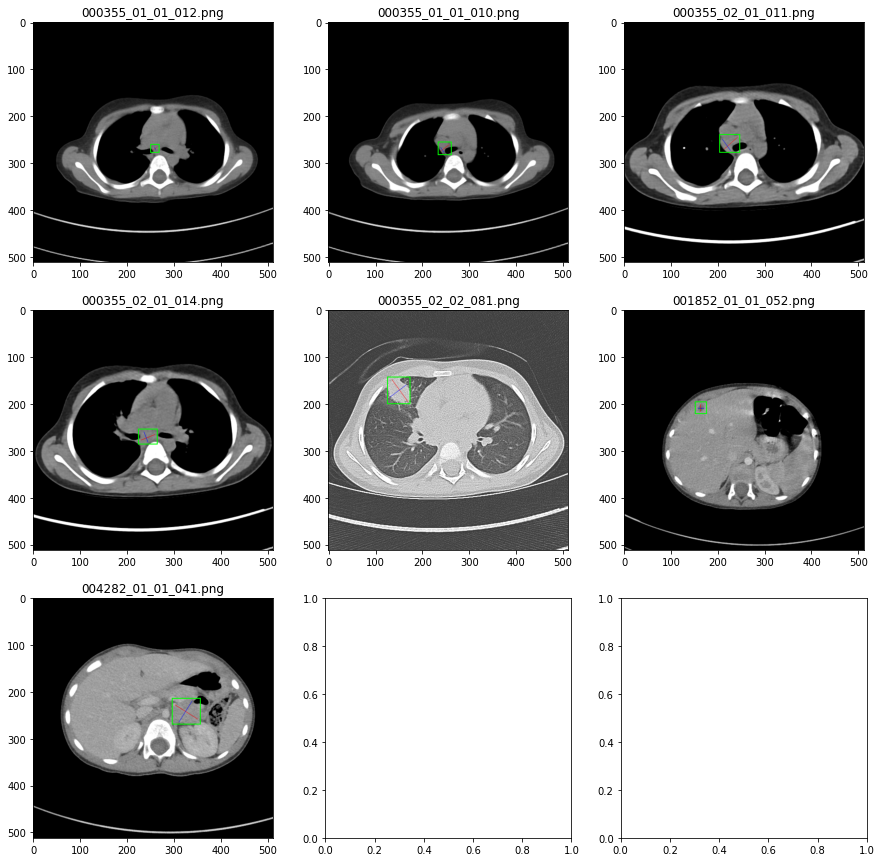

In [6]:
#@title query on csv { run: "auto" }
#inizialize 
res = metadata

#@markdown quali pazienti hanno età compresa tra x e y { run: "auto" }
età_x = 1 #@param {type:"integer"}
età_y = 3 #@param {type:"integer"}
if età_x is not None:
  res = res[(res['Patient_age'] > età_x)]
if età_y is not None:
  res = res[res['Patient_age'] < età_y]

#@markdown filtra i pazienti in base al sesso M/F { run: "auto" }
gender = "M" #@param ["M", "F", ""]
if len(gender)!=0:
  res = res[(res['Patient_gender'] == gender)]

#@markdown filtra i pazienti in base al patient index { run: "auto" }
patient_index = None #@param {type:"integer"}
if patient_index is not None:
  res = res[(res['Patient_index'] == patient_index)]

#@markdown filtra i pazienti in base allo study index { run: "auto" }
study_index = None #@param {type:"integer"}
if study_index is not None:
  res = res[(res['Study_index'] == study_index)]

#@markdown filtra i pazienti in base al filename { run: "auto" }
file_name = "" #@param {type:"string"}
if len(file_name.strip())!=0:
  res = res[(res['File_name'] == file_name.strip())]

#@markdown remove possibly noisy { run: "auto" }
remove_noisy = False #@param {type:"boolean"}
if remove_noisy:
  res = res[(res['Possibly_noisy'] == 0)]


print("# of results: " + str(len(res)))

res = res[:12]
files = []

# create the figure

NROWS = int(len(res)/3) if len(res)%3 == 0 else int((len(res))/3)+1
print(NROWS)
fig, axs = plt.subplots(nrows=NROWS, ncols=3, figsize=(15, 15))
# flatten the axis into a 1-d array to make it easier to access each axes
axs = axs.flatten()
for i, img_name in enumerate(res['File_name']):
  content_images = '/content/deeplesion-smallimages/Key_slices/Key_slices/'+img_name
  pic = plt.imread(content_images)
  axs[i].imshow(pic)
  axs[i].set(title=img_name)

res